In [68]:
from collections import defaultdict
from copy import deepcopy
from datetime import datetime
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core.interchange.dataframe_protocol import DataFrame
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import rand_score, calinski_harabasz_score, silhouette_score
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from sklearn.model_selection import KFold, cross_val_score
%matplotlib inline

## Датасет
https://archive.ics.uci.edu/dataset/342/mice+protein+expression

In [69]:
# fetch dataset
dataset = fetch_ucirepo(id=342)

In [70]:
X = dataset.data.features
y = dataset.data.targets
# data check
X.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior
0,0,0,0,2,5,0,0,2,0,1,...,0,0,0,0,0,0,1,Control,Memantine,C/S
1,0,0,0,2,5,0,0,2,0,1,...,0,0,0,0,0,0,1,Control,Memantine,C/S
2,0,0,0,2,5,0,0,2,0,1,...,0,0,0,0,0,0,1,Control,Memantine,C/S
3,0,0,0,2,4,0,0,2,0,1,...,0,0,0,0,0,0,1,Control,Memantine,C/S
4,0,0,0,2,4,0,0,2,0,1,...,0,0,0,0,0,0,1,Control,Memantine,C/S


In [71]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DYRK1A_N         1077 non-null   float64
 1   ITSN1_N          1077 non-null   float64
 2   BDNF_N           1077 non-null   float64
 3   NR1_N            1077 non-null   float64
 4   NR2A_N           1077 non-null   float64
 5   pAKT_N           1077 non-null   float64
 6   pBRAF_N          1077 non-null   float64
 7   pCAMKII_N        1077 non-null   float64
 8   pCREB_N          1077 non-null   float64
 9   pELK_N           1077 non-null   float64
 10  pERK_N           1077 non-null   float64
 11  pJNK_N           1077 non-null   float64
 12  PKCA_N           1077 non-null   float64
 13  pMEK_N           1077 non-null   float64
 14  pNR1_N           1077 non-null   float64
 15  pNR2A_N          1077 non-null   float64
 16  pNR2B_N          1077 non-null   float64
 17  pPKCAB_N      

Проверим на null и повторяющиеся значения

In [72]:
X.isnull().sum()

DYRK1A_N       3
ITSN1_N        3
BDNF_N         3
NR1_N          3
NR2A_N         3
            ... 
H3MeK4_N     270
CaNA_N         0
Genotype       0
Treatment      0
Behavior       0
Length: 80, dtype: int64

In [73]:
X.duplicated().sum()

np.int64(0)

## Предварительная обработка
Обнаружены некоторые NaN значения, заполним их медианой, строковые значения заменим на числовые

In [74]:
float_cols = X.select_dtypes(include=['float64']).columns
new_X = X.copy()
for col in float_cols:
    new_X.fillna({col: new_X[col].median()}, inplace=True)
for col in new_X.columns.difference(float_cols):
    le = LabelEncoder()
    new_X[col] = le.fit_transform(new_X[col])
new_X.isnull().sum()

DYRK1A_N     0
ITSN1_N      0
BDNF_N       0
NR1_N        0
NR2A_N       0
            ..
H3MeK4_N     0
CaNA_N       0
Genotype     0
Treatment    0
Behavior     0
Length: 80, dtype: int64

### Проанализируем

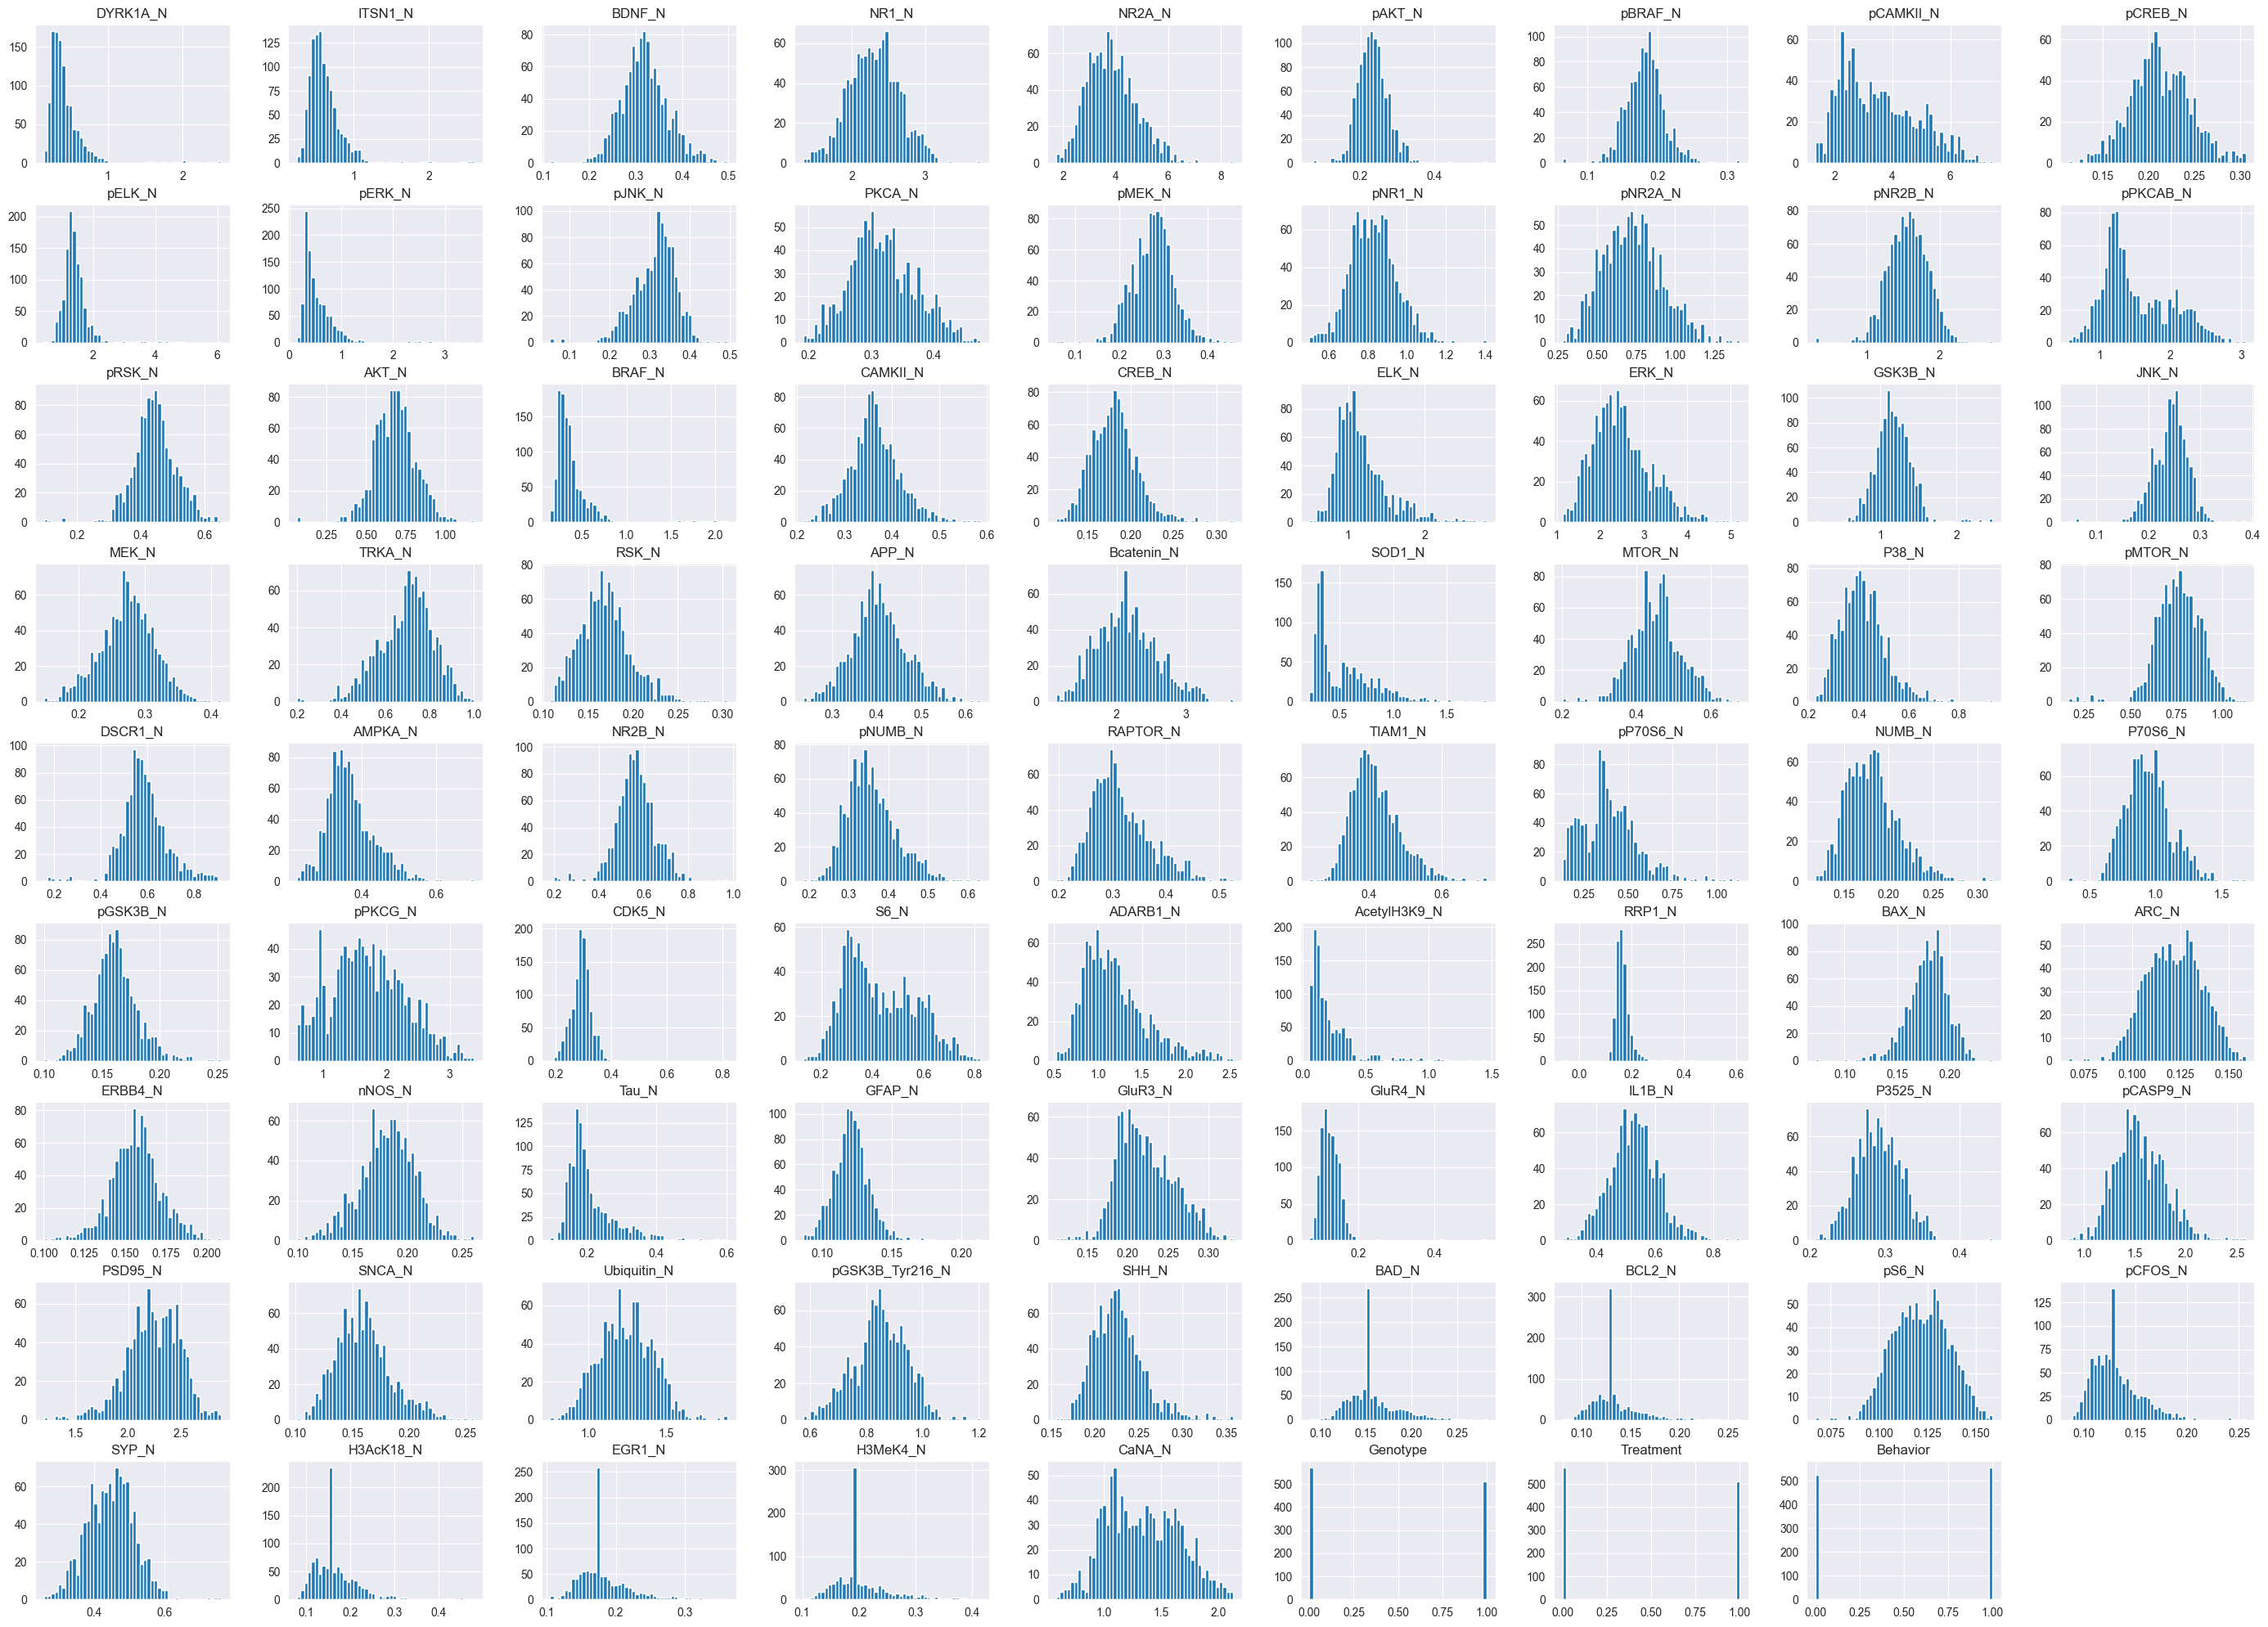

In [75]:
new_X.hist(figsize=(35, 25), bins=50)
plt.show()

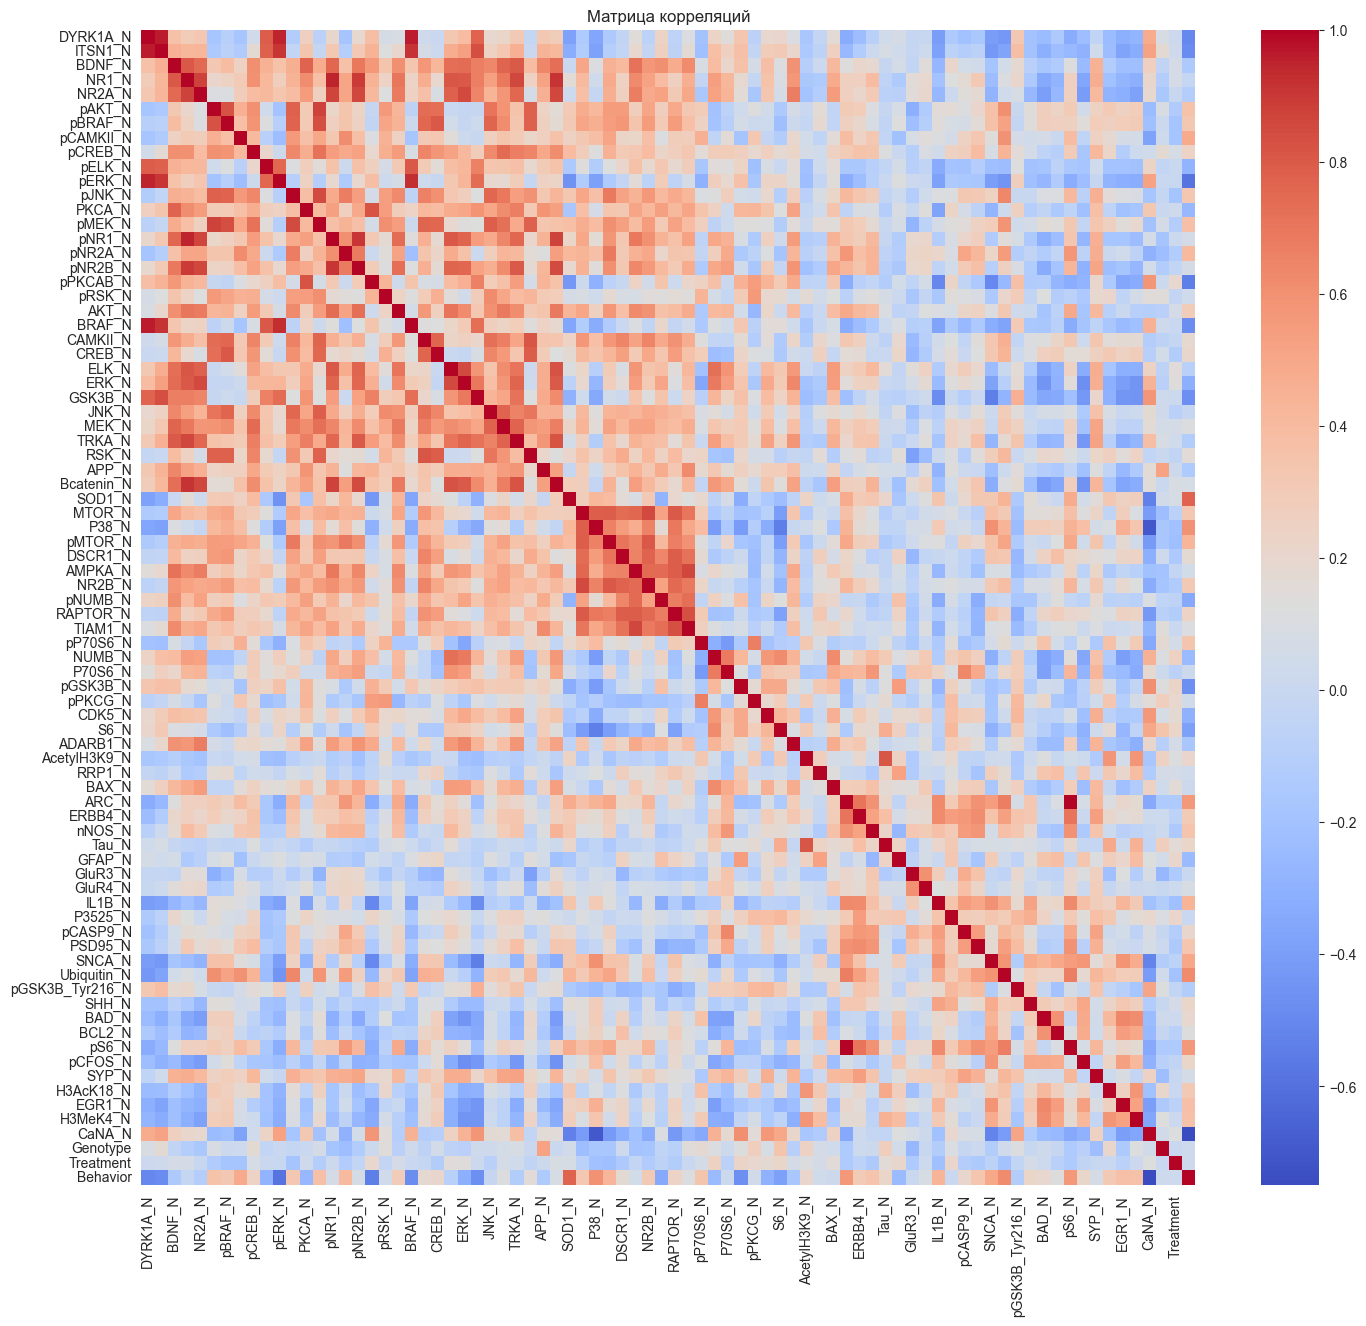

In [76]:
corr = new_X.corr()
plt.figure(figsize=(17, 15))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

Видно, что в датасете есть данные с большой корреляцией, удалим лишние столбцы

In [77]:
corr = corr.abs()

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

X_droped = new_X.drop(columns=to_drop)
print(X_droped.shape)
print(new_X.shape)

(1080, 73)
(1080, 80)


## Разделим датасет

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_droped, y, test_size=0.3, random_state=69)

### Нормализуем

In [79]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# PCA

In [80]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

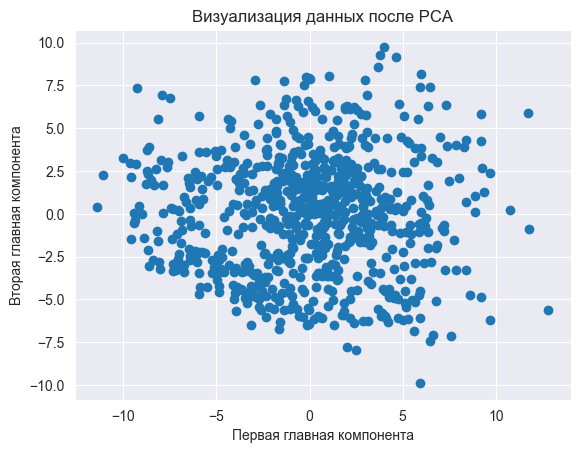

In [81]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Визуализация данных после PCA')
plt.show()

# t-SNE

In [82]:
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(X_train)

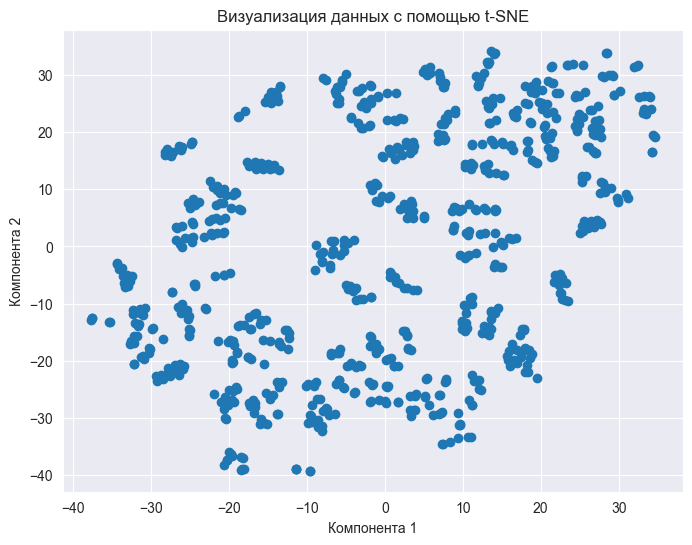

In [83]:
plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1])
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.title('Визуализация данных с помощью t-SNE')
plt.show()

# Реализация K-means

In [84]:
class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=3, max_iters=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.centroids = None

    def _init_centroids(self, X):
        n_samples, n_features = X.shape
        centroids = np.empty((self.n_clusters, n_features))

        idx = np.random.randint(n_samples)
        centroids[0] = X[idx]

        for k in range(1, self.n_clusters):
            distances = np.min(
                np.vstack([np.sum((X - centroids[j])**2, axis=1) for j in range(k)]),
                axis=0
            )
            total = distances.sum()
            if total == 0:
                idx = np.random.randint(n_samples)
            else:
                probabilities = distances / total
                cumulative_probs = np.cumsum(probabilities)
                r = np.random.rand()
                idx = np.searchsorted(cumulative_probs, r)
            centroids[k] = X[idx]
        return centroids

    def fit(self, X, y=None):
        X = np.asarray(X)
        n_samples = X.shape[0]
        if self.random_state is not None:
            np.random.seed(self.random_state)

        self.centroids = self._init_centroids(X)

        for i in range(self.max_iters):
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            new_centroids = []
            for j in range(self.n_clusters):
                if np.any(labels == j):
                    new_centroids.append(X[labels == j].mean(axis=0))
                else:
                    new_centroids.append(X[np.random.choice(n_samples)])
            new_centroids = np.array(new_centroids)

            if np.all(np.linalg.norm(new_centroids - self.centroids, axis=1) < self.tol):
                break

            self.centroids = new_centroids

        self.labels_ = labels
        return self

    def predict(self, X):
        X = np.asarray(X)
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

# Подбор гиперпараметров

In [85]:
# Преобразуем метки в числовой формат для расчёта метрики rand_score
le = LabelEncoder()
numbers = le.fit_transform(y_train.iloc[:, 0])
numbers_test = le.transform(y_test.iloc[:, 0])
clasters = len(y.iloc[:, 0].unique())

# Настроим 5-кратную кросс-валидацию
cv = KFold(n_splits=5, shuffle=True, random_state=69)

### Оптимизация гиперпараметров для MyKMeans

In [86]:
best_score_custom = -np.inf
best_params_custom = None

for max_iter, tol in product(range(100, 1000, 100), [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+0]):
    params = {"n_clusters": clasters, "random_state": 5, "max_iters": max_iter, "tol": tol}
    model = MyKMeans(**params)
    scores = cross_val_score(model, X_train, numbers, scoring="rand_score", cv=cv, n_jobs=-1)
    mean_score = scores.mean()
    # print(f"CustomKMeans: max_iter={max_iter}, rand_score={mean_score:.4f}")
    if mean_score > best_score_custom:
        best_score_custom = mean_score
        best_params_custom = params.copy()

print("Лучшие параметры для CustomKMeans:", best_params_custom)
print("Лучший rand_score:", best_score_custom)

Лучшие параметры для CustomKMeans: {'n_clusters': 8, 'random_state': 5, 'max_iters': 100, 'tol': 0.1}
Лучший rand_score: 0.7944205878935751


### Оптимизация гиперпараметров для sklearn KMeans

In [87]:
best_score_kmeans = -np.inf
best_params_kmeans = None

for max_iter, tol in product(range(100, 1000, 100), [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+0]):
    for init in ['random', 'k-means++']:
        params = {"n_clusters": clasters, "random_state": 5, "tol": tol, "max_iter": max_iter, "init": init}
        model = KMeans(**params)
        scores = cross_val_score(model, X_train, numbers, scoring="rand_score", cv=cv, n_jobs=-1)
        mean_score = scores.mean()
        # print(f"KMeans: max_iter={max_iter}, init={init}, rand_score={mean_score:.4f}")
        if mean_score > best_score_kmeans:
            best_score_kmeans = mean_score
            best_params_kmeans = params.copy()

print("Лучшие параметры для KMeans:", best_params_kmeans)
print("Лучший rand_score:", best_score_kmeans)

Лучшие параметры для KMeans: {'n_clusters': 8, 'random_state': 5, 'tol': 1.0, 'max_iter': 100, 'init': 'k-means++'}
Лучший rand_score: 0.8067751829905891


### Оптимизация гиперпараметров для sklearn Affinity Propogation

In [91]:
best_score_affinity = -np.inf
best_params_affinity = None

for damping in np.arange(0.5, 1.0, 0.1):
    for max_iter, convergence_iter in product(range(100, 1000, 100), range(10, 100, 10)):
        params = {"damping": damping, "max_iter": max_iter, "random_state": 5, "convergence_iter": convergence_iter}
        model = AffinityPropagation(**params)
        scores = cross_val_score(model, X_train, numbers, scoring="adjusted_rand_score", cv=cv, n_jobs=-1)
        mean_score = scores.mean()
        # print(f"AffinityPropagation: damping={damping:.2f}, max_iter={max_iter}, adjusted_rand_score={mean_score:.4f}")
        if mean_score > best_score_affinity:
            best_score_affinity = mean_score
            best_params_affinity = params.copy()

print("\nЛучшие параметры для AffinityPropagation:", best_params_affinity)
print("Лучший adjusted_rand_score:", best_score_affinity)


Лучшие параметры для AffinityPropagation: {'damping': np.float64(0.7999999999999999), 'max_iter': 100, 'random_state': 5, 'convergence_iter': 20}
Лучший adjusted_rand_score: 0.1622469717800573


# Сравнение

In [94]:
# При pca_dims=0 PCA не используется
pca_dims = [0, 3, 10, 20, 30, 40, 50, 60]

results_rand = defaultdict(lambda: [])
results_time = defaultdict(lambda: [])
results_ch = defaultdict(lambda: [])
results_sil = defaultdict(lambda: [])

model_factory = {
    'MyKMeans': lambda: MyKMeans(**best_params_custom),
    'KMeans': lambda: KMeans(**best_params_kmeans),
    'AffinityPropagation': lambda: AffinityPropagation(**best_params_affinity)
}

for n_comp in pca_dims:
    if n_comp != 0:
        pca = PCA(n_components=n_comp)
        reduced_train = pca.fit_transform(X_test)
        reduced_test = pca.transform(X_test)
    else:
        reduced_train = X_train
        reduced_test = X_test

    for name, model in model_factory.items():
        t_start = datetime.now()
        cluster_model = model()
        cluster_model.fit(reduced_train)
        elapsed = (datetime.now() - t_start).total_seconds()

        pred_labels = cluster_model.predict(reduced_test)

        rscore = rand_score(numbers_test, pred_labels)
        ch_score = calinski_harabasz_score(reduced_test, pred_labels)
        sil_score = silhouette_score(reduced_test, pred_labels)

        results_rand[name].append(rscore)
        results_time[name].append(elapsed)
        results_ch[name].append(ch_score)
        results_sil[name].append(sil_score)

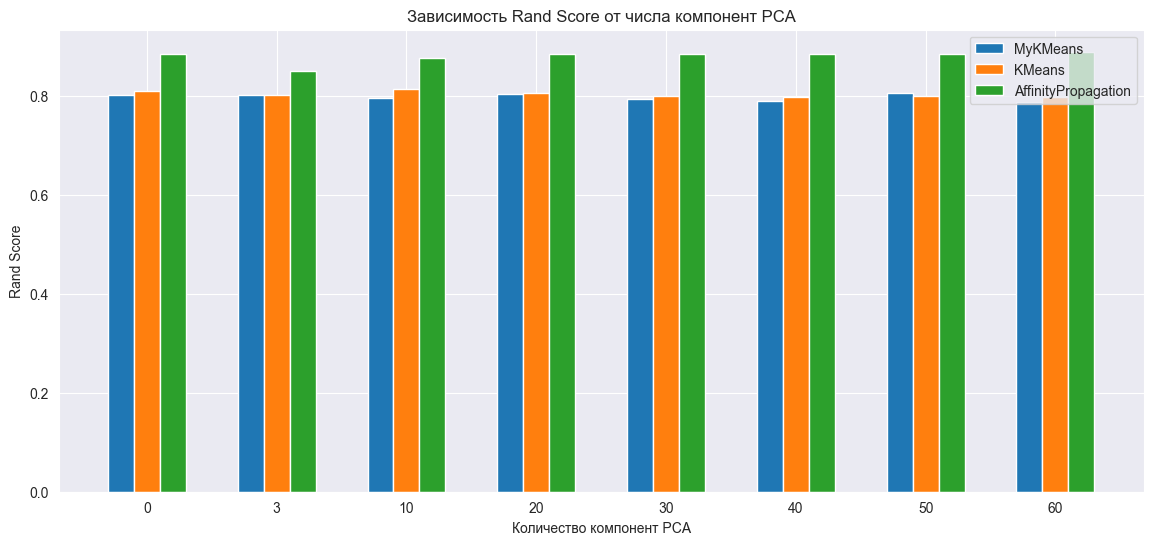

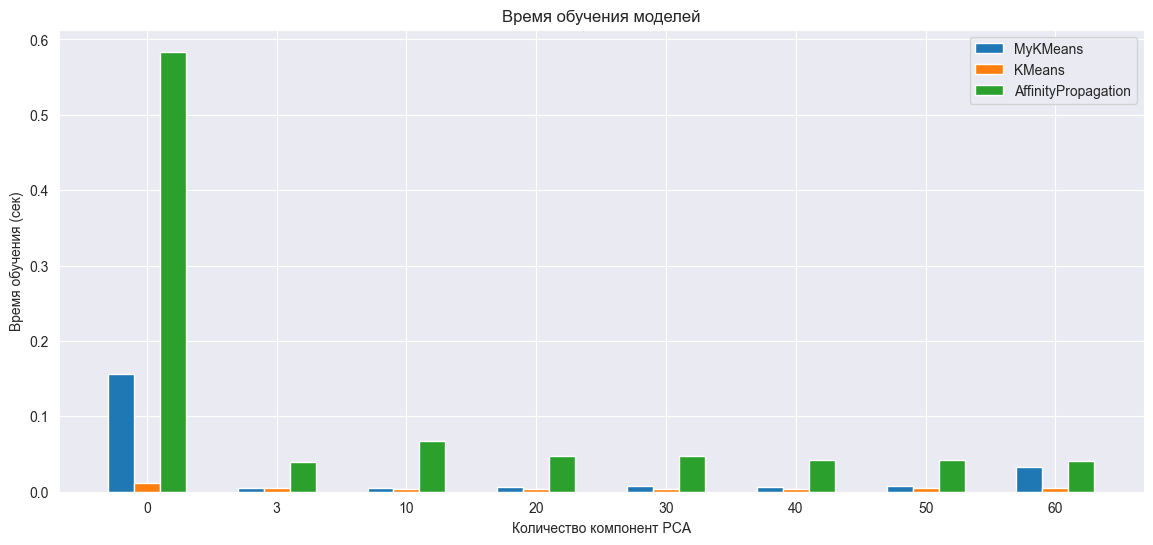

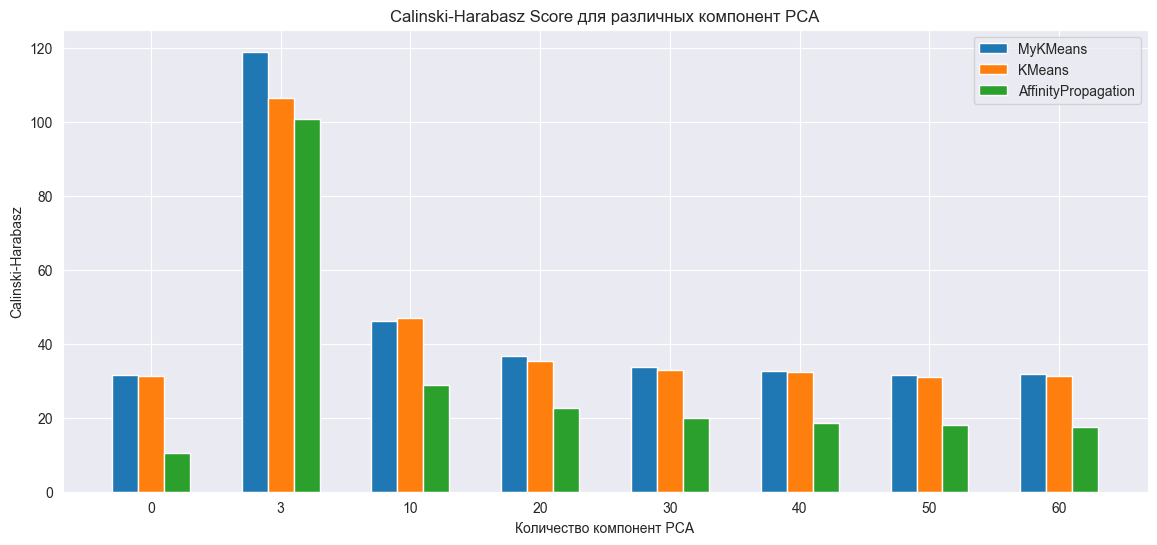

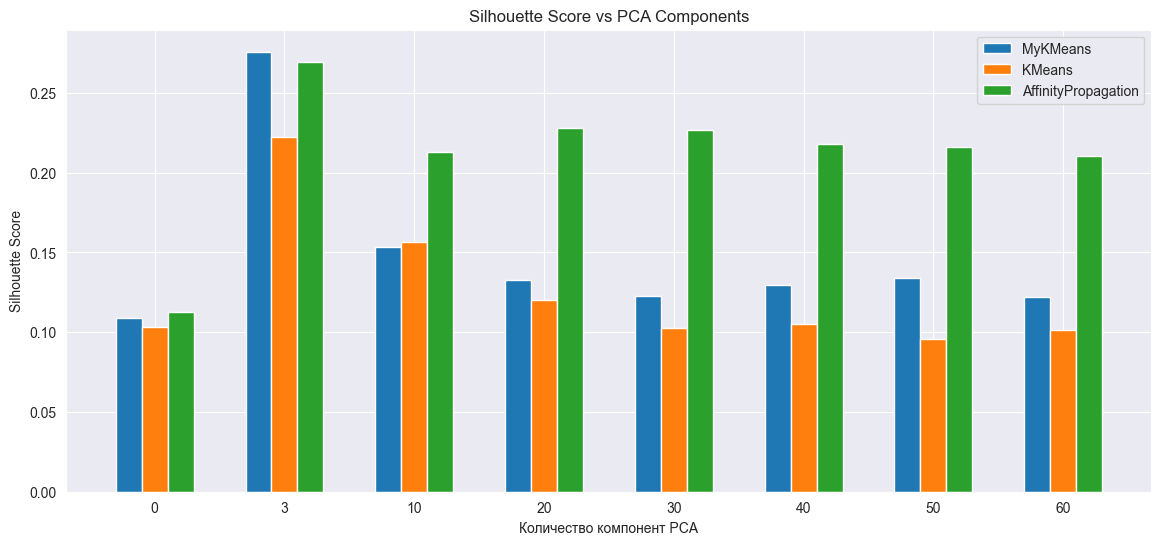

In [96]:
def plot_metric(metric_dict, ylabel, title):
    plt.figure(figsize=(14, 6))
    bar_width = 0.2
    x_pos = np.arange(len(pca_dims))
    for idx, model in enumerate(model_factory.keys()):
        plt.bar(x_pos + idx * bar_width, metric_dict[model], width=bar_width, label=model)
    plt.xlabel('Количество компонент PCA')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(x_pos + bar_width, pca_dims)
    plt.legend()
    plt.grid(True, axis='y')
    plt.show()


plot_metric(results_rand, 'Rand Score', 'Зависимость Rand Score от числа компонент PCA')
plot_metric(results_time, 'Время обучения (сек)', 'Время обучения моделей')
plot_metric(results_ch, 'Calinski-Harabasz', 'Calinski-Harabasz Score для различных компонент PCA')
plot_metric(results_sil, 'Silhouette Score', 'Silhouette Score vs PCA Components')

### Вывод
Affinity Propagation показал себя лучше всего, хоть и ему требуется наибольшее время на тренировку. MyKMeans и KMeans показали себя примерно одинаково, за исключение времени на тренировку, где MyKMeans сильно отстает.

# Итог
- [x] Найдены данные с количеством признаков хотя бы 50 - Mice Protein Expression с 80-ю признаками
- [x] Проведен разведочный анализ (**EDA**). Обработаны строковые и None значений, данные нормализованы.
- [x] Реализован один из алгоритмов кластеризации - **K-means**.
- [x] Обучены моя модель кластеризации, а также **sklearn** **KMeans** и **Affinity Propogation**.
- [x] При обучении использован **подбор гиперпараметров**.
- [x] Сравнено качество моделей: замерена скорость обучения, вычислены различные метрики качества.
- [x] (**+3 балла**) Снижена размерность данных с помощью метода главных компонент **PCA** и исследовано качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [x] (**+2 балла**) Визуализированы данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**.
